In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

import sys
sys.path.append("../slow_extraction_tutorial")
import plot_helpers

import pandas as pd

In [3]:
# Read MAD-X sequence from file (using cpymad)
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=False)
mad.call('../../LATTICE/Prova3.seq')
mad.beam()
mad.use('CNAO3S0')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.11.28 16:19:15      +
  ++++++++++++++++++++++++++++++++++++++++++++
assign, echo=output.out;





TITLE, "CNAO SYNC";







S0_001A_MBS: SBEND, L= 1.6772, 

E1 := 0.19634954085, E2 := 0.19634954085, ANGLE = 0.3926990817, 

K0 := 0.3926990817/1.6772, K1 := 0, K2 := 0, 

HGAP = 0.036, FINT:=FINTVAL;

S0_001B_TSP: MARKER;

S0_002A_DRI: DRIFT, L= 0.2101525103;

S0_003A_FLS: MARKER;

S0_004A_DRI: DRIFT, L= 0.109;

S0_005A_QUS: QUADRUPOLE, L= 0.36, 

K1 := KF;



S0_006A_BS1: MARKER;

S0_007A_DRI: DRIFT, L= 0.101;

S0_008A_FLS: MARKER;

S0_009A_PUH: HMONITOR, L= 0.3;

S0_010A_FLS: MARKER;

S0_011A_DRI: DRIFT, L= 0.061;

S0_012A_SSM: MARKER;

S0_013A_DRI: DRIFT, L= 0.056;

S0_014A_DIA: MARKER;

S0_015A_DRI: DRIFT, L= 0.033;

S0_016A_MSP: DRIFT, L= 0.65;

S0_017A_DRI: DRIFT, L= 0.9

In [4]:
# Import in Xsuite
line = xt.Line.from_madx_sequence(mad.sequence.CNAO3S0,
                                  deferred_expressions=True)

Converting sequence "cnao3s0":   0%|          | 0/392 [00:00<?, ?it/s]

In [5]:
# Choose the appropriate bend model
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=15)

In [6]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=200e8) # eV

### Match

In [7]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-1, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.667, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 1.266         
Matching: model call n. 30               
Optimize - end penalty:  1.31471e-06


In [8]:
line.build_tracker()

The line already has an associated tracker


### Visualize the phase space topology

In [9]:
# Generate 20 particles on the x axis
x_gen = np.linspace(0, 2.5e-2, 20)
particles = line.build_particles(x=x_gen,px=0,y=0,py=0,delta=0)
# Inspect the particles
particles.get_table()

Table: 20 rows, 28 cols
particle_id                       s             x            px             y            py ...
0                                 0             0             0             0             0
1                                 0    0.00131579             0             0             0
2                                 0    0.00263158             0             0             0
3                                 0    0.00394737             0             0             0
4                                 0    0.00526316             0             0             0
5                                 0    0.00657895             0             0             0
6                                 0    0.00789474             0             0             0
7                                 0    0.00921053             0             0             0
8                                 0     0.0105263             0             0             0
9                                 0     0.0118421   

In [10]:
# Track 1000 turns logging turn-by-turn data
num_turns = 10000
line.track(particles,num_turns=num_turns, turn_by_turn_monitor=True)
rec = line.record_last_track

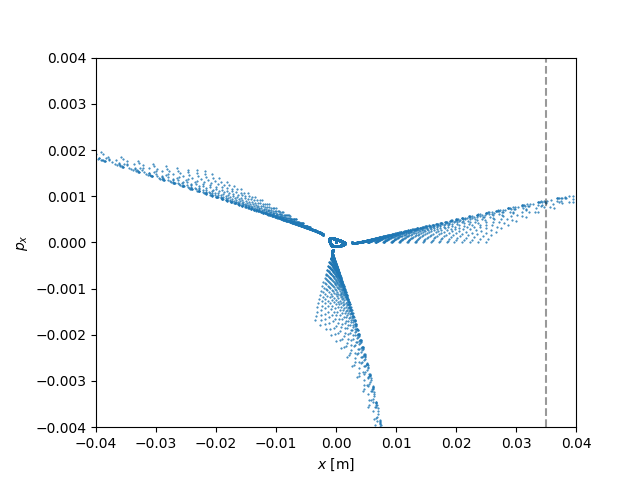

In [11]:
# Plot turn by turn data
plt.figure()
plt.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')
plt.xlim(-4e-2, 4e-2)
plt.ylim(-4e-3, 4e-3)
plt.subplots_adjust(left=.15)

# Mark septum position
x_septum = 3.5e-2
plt.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')

In [12]:
# Compute normalized coordinates
tw = line.twiss(method='4d')
nc = tw.get_normalized_coordinates(rec)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


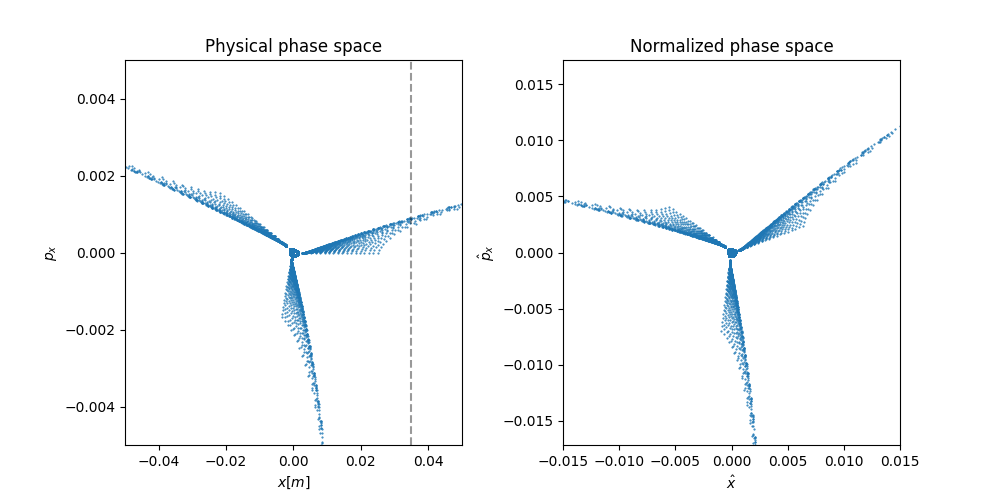

In [13]:
# Plot side by side
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot

ax_geom.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm.T, nc.px_norm.T,
           '.', markersize=1, color='C0')
ax_geom.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')

## Find separatrix

In [14]:
# We use some logic written in python to localize the transition
# between stable and unstable motion

# Sepratrix search region
search_region = [0, 0.03]

while search_region[1] - search_region[0] > 1e-6:
    
    # Generate a particle in the middle of the region
    x_test = (search_region[0] + search_region[1]) / 2
    p = line.build_particles(x=x_test, px=0)
    
    # Track
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    rec_test = line.record_last_track
    
    # Update the search region
    if (rec_test.x > x_septum).any():
        # Test particle is unstable
        # => Sepearatrix is on the right w.r.t x_test
        search_region[1] = x_test
    else:
        # Test particle is stable
        # Sepearatrix is on the left w.r.t x_test
        search_region[0] = x_test

In [15]:
################## Set a rectangular aperture limit ######################
xt.LimitRect(max_x=x_septum) # Insert it before building the tracker
###########################################################################

# We track particles at the outer edge of narrowed-down search region
p = line.build_particles(x=search_region[1])
line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
rec_separ = line.record_last_track

# Get corresponding normalized coordinates
nc_separ = tw.get_normalized_coordinates(rec_separ)

### Plot separatrix

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


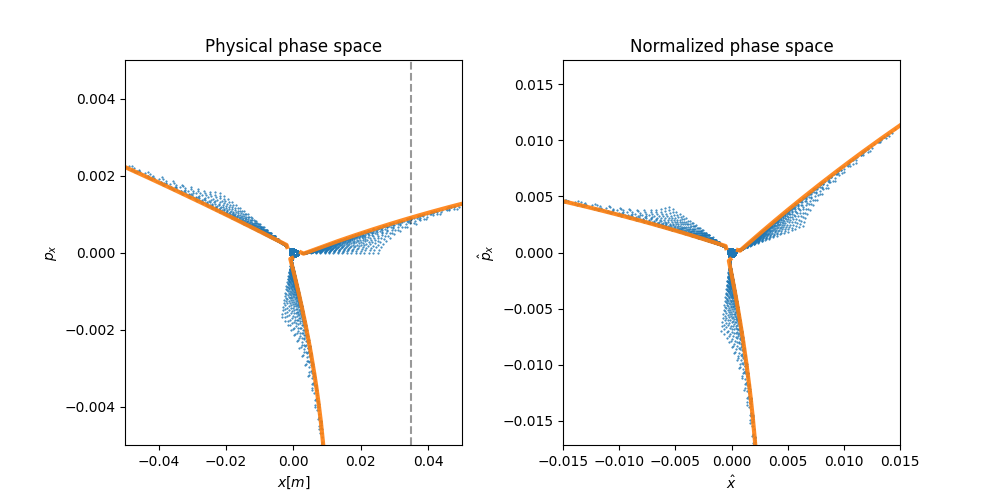

In [16]:
# Plot phase space topology (as above)
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot

ax_geom.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm.T, nc.px_norm.T,
           '.', markersize=1, color='C0')
ax_geom.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')

# Overlap found separatrix
mask_alive = rec_separ.state > 0
for ii in range(3):
    ax_geom.plot(rec_separ.x[mask_alive][ii::3],
                 rec_separ.px[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)
    ax_norm.plot(nc_separ.x_norm[mask_alive][ii::3],
                 nc_separ.px_norm[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)    

### Measure the slope of the separatrix at the septum

In [17]:
x_separ = rec_separ.x[0, :]
px_separ = rec_separ.px[0, :]

# Find turn at which particle was closer to the septum
i_septum = np.argmin(np.abs(x_separ - x_septum))


# Fit a straight line using the previous and the following passage
# (takes three turns to come back to the same branch)
poly_sep = np.polyfit([x_separ[i_septum ], x_separ[i_septum - 3]],
                      [px_separ[i_septum ], px_separ[i_septum - 3]],
                       deg=1)
dpx_dx_at_septum = poly_sep[0]
print('dpx_dx_at_septum = ', dpx_dx_at_septum)

dpx_dx_at_septum =  0.026114207461190742


In [18]:
# px where the least square straight line crosses the electrostatic septum
px_at_septum = np.polyval(poly_sep, x_septum)
px_at_septum

np.float64(0.0009073338300312681)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


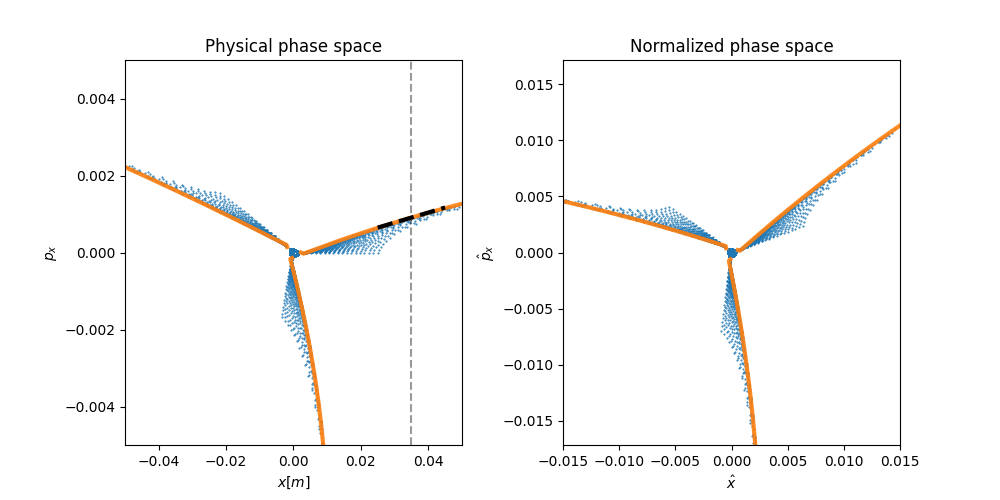

In [19]:
# Re-plot with fitted line
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot

ax_geom.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm.T, nc.px_norm.T,
           '.', markersize=1, color='C0')
ax_geom.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')

# Overlap found separatrix
mask_alive = rec_separ.state > 0
for ii in range(3):
    ax_geom.plot(rec_separ.x[mask_alive][ii::3],
                 rec_separ.px[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)
    ax_norm.plot(nc_separ.x_norm[mask_alive][ii::3],
                 nc_separ.px_norm[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)  
x_plt = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k', linewidth=3)



### Plot boundary of the stable area

In [20]:
# We track particles at the inner edge of narrowed-down search region
p = line.build_particles(x=search_region[0])
line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
rec_triang = line.record_last_track

# Get corresponding normalized coordinates
nc_triang = tw.get_normalized_coordinates(rec_triang)

In [21]:
x_triang = rec_triang.x[0, :]
px_triang = rec_triang.px[0, :]
x_norm_triang = nc_triang.x_norm[0, :]
px_norm_triang = nc_triang.px_norm[0, :]

# Sort boundary coordinates with increawinf theta
theta_triang = np.angle(x_norm_triang + 1j * px_norm_triang)
i_sorted = np.argsort(theta_triang)

x_triang = x_triang[i_sorted]
px_triang = px_triang[i_sorted]
x_norm_triang = x_norm_triang[i_sorted]
px_norm_triang = px_norm_triang[i_sorted]

### Re-plot with stable triangle

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


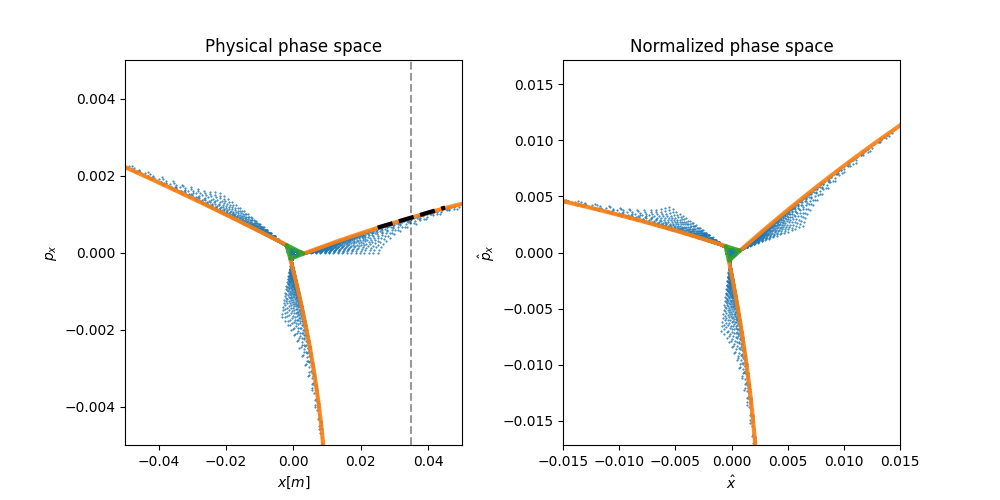

In [22]:
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot
ax_geom.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm.T, nc.px_norm.T,
           '.', markersize=1, color='C0')
ax_geom.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')
for ii in range(3):
    ax_geom.plot(rec_separ.x[mask_alive][ii::3],
                 rec_separ.px[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)
    ax_norm.plot(nc_separ.x_norm[mask_alive][ii::3],
                 nc_separ.px_norm[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)

x_plt = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k', linewidth=3)

ax_norm.plot(x_norm_triang, px_norm_triang,
                     '-', lw=3, color='C2', alpha=0.9)
ax_geom.plot(x_triang, px_triang, '-', lw=3, color='C2', alpha=0.9)

### Find fixed points

In [23]:
z_triang_norm = nc_triang.x_norm[0, :] + 1j * nc_triang.px_norm[0, :]
z_triang = rec_triang.x[0, :] + 1j * rec_triang.px[0, :]
r_triang_norm = np.abs(z_triang_norm)

# Search for the point on the triangle with the maximum amplitude
i_fp1 = np.argmax(r_triang_norm)
z_fp1 = z_triang_norm[i_fp1]
r_fp1 = np.abs(z_fp1)

# Search for local maximum amplitude at +/- 120 deg from the first fixed point
mask_fp2 = np.abs(z_triang_norm - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
i_fp2 = np.argmax(r_triang_norm * mask_fp2)
mask_fp3 = np.abs(z_triang_norm - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
i_fp3 = np.argmax(r_triang_norm * mask_fp3)

# Build array with fixed points
x_norm_fp = z_triang_norm[[i_fp1, i_fp2, i_fp3]].real
px_norm_fp = z_triang_norm[[i_fp1, i_fp2, i_fp3]].imag
x_fp = z_triang[[i_fp1, i_fp2, i_fp3]].real
px_fp = z_triang[[i_fp1, i_fp2, i_fp3]].imag

In [24]:
x_norm_fp

array([-0.00023677,  0.00074285, -0.00050779])

### Re-plot with fixed points

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[-0.0009322   0.00292262 -0.00199868]
[-1.61073863e-04 -3.09109591e-05  1.91211032e-04]


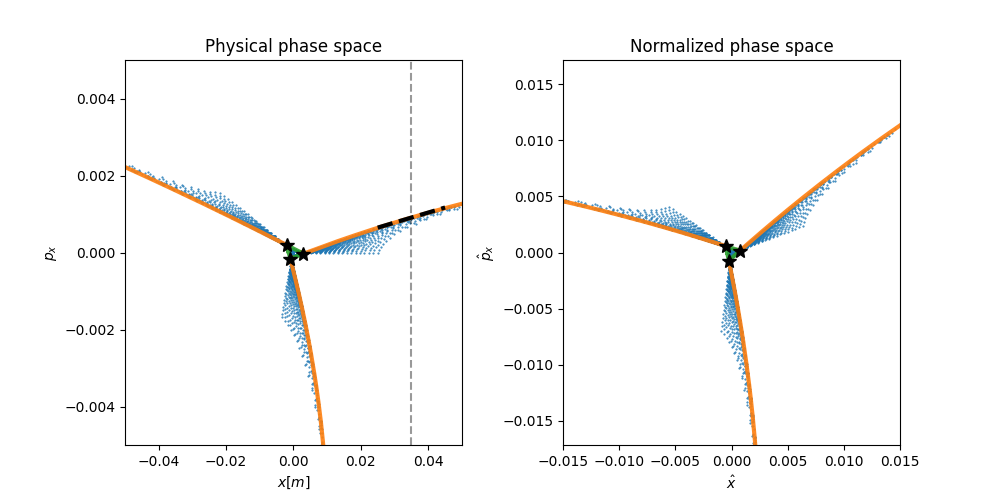

In [25]:
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot
ax_geom.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm.T, nc.px_norm.T,
           '.', markersize=1, color='C0')
ax_geom.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')
for ii in range(3):
    ax_geom.plot(rec_separ.x[mask_alive][ii::3],
                 rec_separ.px[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)
    ax_norm.plot(nc_separ.x_norm[mask_alive][ii::3],
                 nc_separ.px_norm[mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)

x_plt = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k', linewidth=3)
ax_norm.plot(x_norm_triang, px_norm_triang,
                     '-', lw=3, color='C2', alpha=0.9)
ax_geom.plot(x_triang, px_triang, '-', lw=3, color='C2', alpha=0.9)

ax_norm.plot(x_norm_fp, px_norm_fp, '*', markersize=10, color='k')
ax_geom.plot(x_fp, px_fp, '*', markersize=10, color='k')

print(x_fp)
print(px_fp)

### Compute area of the stable region

In [26]:
# Area of the stable regions (determinant of the matrix with the vertices)
stable_area = np.linalg.det([x_norm_fp, px_norm_fp, [1, 1, 1]])
physical_stable_area = np.linalg.det([x_fp, px_fp, [1, 1, 1]])

### Summary of the computed quantities

In [27]:
print(f'{dpx_dx_at_septum=}')
print(f'{stable_area=}')
print(f'{physical_stable_area=}')
print(f'{x_fp=}')
print(f'{px_fp=}')
print(f'{x_norm_fp=}')
print(f'{px_norm_fp=}')

dpx_dx_at_septum=np.float64(0.026114207461190742)
stable_area=np.float64(1.496810162616855e-06)
physical_stable_area=np.float64(1.496810162616855e-06)
x_fp=array([-0.0009322 ,  0.00292262, -0.00199868])
px_fp=array([-1.61073863e-04, -3.09109591e-05,  1.91211032e-04])
x_norm_fp=array([-0.00023677,  0.00074285, -0.00050779])
px_norm_fp=array([-0.00072203,  0.00015372,  0.00056363])
